# Semantic Segmentation with VGG-UNet

This notebook demonstrates an image segmentation pipeline using a pretrained VGG-based UNet model. The goal is to perform pixel-wise classification over input images using deep learning, with a focus on clean modular code and visualization.

The pipeline includes data preparation, model loading, prediction, and visualization of segmentation masks.

## Setup & Imports

The following packages are required:
- `keras` and `keras-segmentation`
- `opencv-python`
- `matplotlib`
- `numpy`

Make sure the required `utils.py` is present in the working directory with all helper functions.

## Image Preprocessing

This section handles image loading, resizing, and any necessary transformations to prepare images for segmentation. The preprocessing is designed to match the input format expected by the VGG-UNet model.

## Model Setup & Prediction

A pretrained VGG-UNet model is loaded for segmentation. The model is applied on the processed images, and output masks are generated. This can be adapted to any dataset with minimal changes.

## Results & Visualization

Segmentation masks are overlaid on the original images to visually inspect the model performance. The output helps in evaluating model generalization and accuracy qualitatively.

## Notes & Next Steps

- This notebook can be extended with custom datasets and fine-tuning.
- Quantitative metrics like IoU or Dice Score can be added for performance evaluation.
- Ensure images and masks are aligned correctly for supervised training.

All proprietary elements have been stripped for public sharing.

In [8]:
import os
import random
import ast
import shutil
import ast
import cv2
import numpy as np


import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import keras

from utils import *
from keras_segmentation.models.unet import vgg_unet

In [29]:
# Data Prep Step
img_path = '/Users/parameshwaraniyer/Downloads/images/'
img_tag_path = '/Users/parameshwaraniyer/Downloads/labels_stitched_1280x1280/poly_xy_footprints/'
img_type = '.' + os.listdir(img_path)[0].split('.')[1]
ann_type = '.' + os.listdir(img_tag_path)[0].split('.')[1]

# User defined vars
proj_folder = 'footprint_extraction'
train_img_folder = 'train_images'
train_seg_folder = 'train_seg'
val_img_folder = 'val_images'
val_seg_folder = 'val_seg'
random_sample = 100
train_ratio = 0.7

# 1. Extract file names and create a random sample for train & val
file_list = file_name_extract(img_path)
random_files = random.sample(file_list,random_sample)

train_samples = round(train_ratio*random_sample)
train_samples = random_files[:train_samples]
val_samples = round((1-train_ratio)*random_sample)
val_samples = random_files[-val_samples:]

#2. prep folder structure
proj_loc = os.path.join(os.getcwd(),proj_folder)
train_img_loc = os.path.join(os.getcwd(),proj_folder,train_img_folder)
val_img_loc = os.path.join(os.getcwd(),proj_folder,val_img_folder)
train_seg_loc = os.path.join(os.getcwd(),proj_folder,train_seg_folder)
val_seg_loc = os.path.join(os.getcwd(),proj_folder,val_seg_folder)


if (os.path.isdir(proj_loc)):
    shutil.rmtree(proj_loc,ignore_errors= True)

os.makedirs(train_img_loc)
os.makedirs(val_img_loc)
os.makedirs(train_seg_loc)
os.makedirs(val_seg_loc)

#3. Copy raw images into structure
copy_files(img_path, train_img_loc, train_samples, img_type)
copy_files(img_path, val_img_loc, val_samples, img_type)

#4. Create masks & insert into structure
copy_files(img_path, train_img_loc, train_samples, img_type)
copy_files(img_path, val_img_loc, val_samples, img_type)

create_mask_files(img_tag_path,train_seg_loc,train_samples,img_type,ann_type)
create_mask_files(img_tag_path,val_seg_loc,val_samples,img_type,ann_type)

In [30]:
#Running data prep tests
display(test_file_names(train_img_loc,train_seg_loc))
display(test_file_names(val_img_loc,val_seg_loc))

'Pass'

'Pass'

Text(0.5, 1.0, 'Segmented Tagged Image')

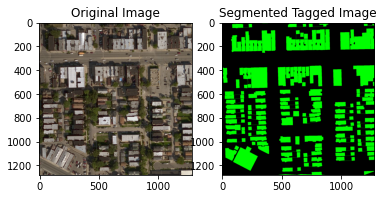

In [31]:
#Visualizing the raw images & masks
file_name = train_samples[5] + img_type 


plt.subplot(1,2,1)
img = mpimg.imread(os.path.join(train_img_loc, file_name))
plt.imshow(img)
plt.title('Original Image')

plt.subplot(1,2,2)
img = mpimg.imread(os.path.join(train_seg_loc, file_name))
plt.imshow(img)
plt.title('Segmented Tagged Image')
    

In [32]:
# Model building
model = vgg_unet(n_classes=2 ,  input_height=64, input_width=64  )
model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

model.train( 
    train_images =  train_img_loc,
    train_annotations = train_seg_loc,
     epochs=5 
)


  3%|▎         | 2/70 [00:00<00:05, 12.40it/s]

Verifying training dataset


100%|██████████| 70/70 [00:05<00:00, 12.32it/s]


Dataset verified! 
Epoch 1/5
512/512 [==============================] - 107s 209ms/step - loss: 0.9991 - accuracy: 0.5202
Epoch 2/5
512/512 [==============================] - 103s 201ms/step - loss: 0.8002 - accuracy: 0.5416
Epoch 3/5
512/512 [==============================] - 101s 197ms/step - loss: 0.7048 - accuracy: 0.5849
Epoch 4/5
512/512 [==============================] - 97s 188ms/step - loss: 0.6451 - accuracy: 0.6331
Epoch 5/5
512/512 [==============================] - 98s 191ms/step - loss: 0.5952 - accuracy: 0.6860


Text(0.5, 1.0, 'PredictedImage')

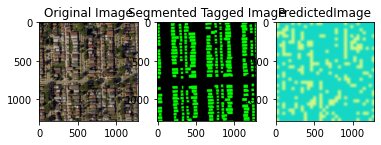

In [38]:
file_name = val_samples[19] + img_type 
out_file = val_samples[19] + 'output' + img_type

plt.subplot(1,3,1)
img = mpimg.imread(os.path.join(val_img_loc, file_name))
plt.imshow(img)
plt.title('Original Image')

plt.subplot(1,3,2)
img = mpimg.imread(os.path.join(val_seg_loc, file_name))
plt.imshow(img)
plt.title('Segmented Tagged Image')
 

out = model.predict_segmentation(
    inp = os.path.join(val_img_loc, file_name),
    out_fname=out_file
)

plt.subplot(1,3,3)
img = mpimg.imread(out_file)
plt.imshow(img)
plt.title('PredictedImage')